# Quasars Version 2:
## The purpose of this notebook is to present the findings of quasars.pynb in a neater way. 
## Everything is done at z = 1 for simplicity

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import weightedstats as ws
from sigma_m import sigma_m
from halo_mass_function import halo_mass_function
from halo2bh import halo2bh
from schechterLedd import schechterLedd
%matplotlib inline

## Generate a sample of uniformly distributed halo masses (and calculate hmf)

In [2]:
n = np.ones(1000)
halomassrange = np.logspace(12, 16, 1000)

halocdf = np.cumsum(n)

randomPoints = np.random.uniform(min(halocdf), max(halocdf), size = 10000000)
hminterpf = interp1d(halocdf, halomassrange)
mhalo = hminterpf(randomPoints)

In [3]:
hmf_small = halo_mass_function(halomassrange, 1.0)

In [4]:
HMFf = interp1d(halomassrange, hmf_small)
hmf = HMFf(mhalo)

## Generate a sample of uniformly distributed Eddington ratios (and calculate schechter)

In [5]:
n = np.ones(10000)
leddrange = np.logspace(-4, 0, 10000)

leddcdf = np.cumsum(n)

randomledd = np.random.uniform(min(leddcdf), max(leddcdf), size = 10000000)
leddinterpf = interp1d(leddcdf, leddrange)
ledd = leddinterpf(randomledd)

In [6]:
schech_small = schechterLedd(leddrange)

In [7]:
schechF = interp1d(leddrange, schech_small)
schech = schechF(ledd)

## Calculate weights based on hmf and schech

In [8]:
weights = hmf * schech

## Get Ricci et al 2017 $f_{obsc}$ distribution for my sample

In [9]:
rlogLedd = [-5.8, -4.9, -3.8, -3.0, -2.2, -1.7, -1.2, -0.8, -0.2]
rfobs = [0.4, 0.4, 0.75, 0.85, 0.75, 0.70, 0.30, 0.05, 0.02]

In [10]:
fobscF = interp1d(rlogLedd, rfobs, bounds_error = False)
fobscdist = fobscF(np.log10(ledd))

## Determine which halos are obscured

In [11]:
weights = weights/max(weights)

In [12]:
fobsc_rand = np.random.random(size = len(fobscdist))

obscuredFlag = fobsc_rand < fobscdist ### True means obscured
unobscuredFlag = fobsc_rand >= fobscdist

/Users/kellywhalen/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kellywhalen/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


In [13]:
obscured_masses = mhalo[obscuredFlag]
unobscured_masses = mhalo[unobscuredFlag]

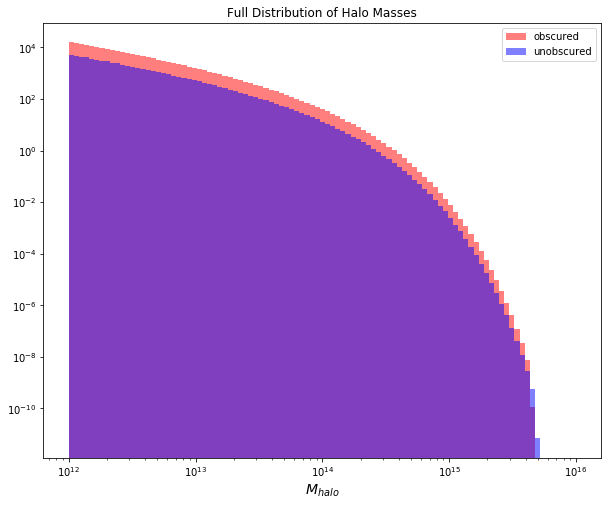

In [14]:
plt.figure(figsize = (10,8))
plt.hist(obscured_masses, weights = weights[obscuredFlag], bins = np.logspace(12, 16, 100), range = (min(mhalo), max(mhalo)), label = 'obscured', color = 'red', alpha = 0.5)[2]
plt.hist(unobscured_masses, weights = weights[unobscuredFlag], bins = np.logspace(12, 16, 100), range = (min(mhalo), max(mhalo)), label = 'unobscured', color = 'blue', alpha = 0.5)[2]                                            
axes = plt.gca()
axes.set_xscale("log")
axes.set_yscale("log")
plt.legend()
plt.xlabel('$M_{halo}$', fontsize = 14)
plt.title('Full Distribution of Halo Masses')
                            

## Apply a luminosity cut

### convert from halo mass to black hole mass

In [15]:
bhmass, bhmf = halo2bh(mhalo, hmf)

### Calculate Luminosities [$L_{\odot}$] using these $M_{BH}$ and $\lambda _{edd}$ 

In [16]:
luminosities = ledd * bhmass *3.2e4

In [17]:
Lcut = 10**(45.8) /  3.826e33 

In [18]:
lumFlag = luminosities > Lcut

In [19]:
obsclumFlag = lumFlag[obscuredFlag]
unobsclumFlag = lumFlag[unobscuredFlag]

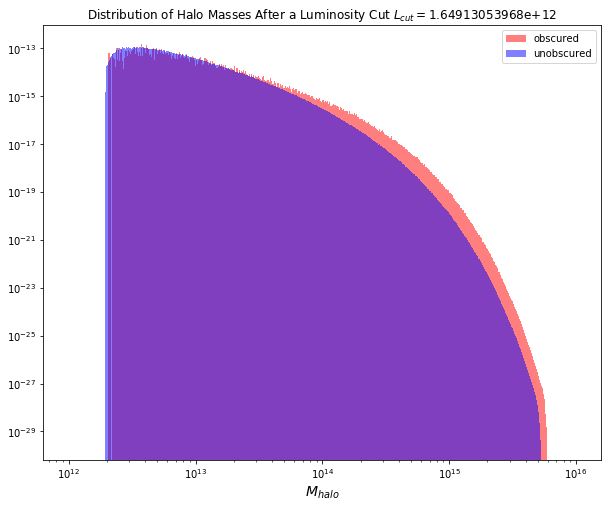

In [20]:
plt.figure(figsize = (10,8))
plt.hist(obscured_masses[obsclumFlag], weights = weights[obscuredFlag][obsclumFlag], bins = np.logspace(12, 16, 1000), range = (min(mhalo), max(mhalo)), label = 'obscured', color = 'red', alpha = 0.5, normed = True)[2]
plt.hist(unobscured_masses[unobsclumFlag], weights = weights[unobscuredFlag][unobsclumFlag], bins = np.logspace(12, 16, 1000), range = (min(mhalo), max(mhalo)), label = 'unobscured', color = 'blue', alpha = 0.5, normed = True)[2]                                            
axes = plt.gca()
axes.set_xscale("log")
axes.set_yscale("log")
plt.legend()
plt.xlabel('$M_{halo}$', fontsize = 14)
plt.title('Distribution of Halo Masses After a Luminosity Cut $L_{cut} = $' + str(10**(45.8) /  3.826e33))

In [21]:
obscmean = np.average(obscured_masses[obsclumFlag], weights = weights[obscuredFlag][obsclumFlag])
unobscmean = np.average(unobscured_masses[unobsclumFlag], weights = weights[unobscuredFlag][unobsclumFlag])

print "Weighted Averages"
print "Obscured: " + str(obscmean)
print "Unobscured: " + str(unobscmean)

Weighted Averages
Obscured: 2.31267029237e+13
Unobscured: 1.54605826059e+13


In [22]:
obscmed = ws.weighted_median(obscured_masses[obsclumFlag], weights = weights[obscuredFlag][obsclumFlag])
unobscmed = ws.weighted_median(unobscured_masses[unobsclumFlag], weights = weights[unobscuredFlag][unobsclumFlag])

print "Weighted Medians"
print "Obscured: " + str(obscmed)
print "Unobscured: " + str(unobscmed)

Weighted Medians
Obscured: 1.02594423361e+13
Unobscured: 8.08295199193e+12


## Recreate DiPompeo et al. 2017 Figure 4

In [31]:
Lcutrange = np.logspace(np.log10(10**(44)/ 3.826e33), np.log10(10**(47)/ 3.826e33), 10)
obschalomed = np.zeros(10)
unobschalomed = np.zeros(10)
index = 0

In [32]:
for lcut in Lcutrange:
    
    lumFlag = luminosities > lcut
    obsclumFlag = lumFlag[obscuredFlag]
    unobsclumFlag = lumFlag[unobscuredFlag]
    
    obscuredHalos = obscured_masses[obsclumFlag] 
    unobscuredHalos = unobscured_masses[unobsclumFlag] 
    
    obschalomed[index] = ws.weighted_median(obscuredHalos, weights = weights[obscuredFlag][obsclumFlag])
    unobschalomed[index] = ws.weighted_median(unobscuredHalos, weights = weights[unobscuredFlag][unobsclumFlag])
    
    index = index + 1
    print 'One round done'

One round done
One round done
One round done
One round done
One round done
One round done
One round done
One round done
One round done
One round done


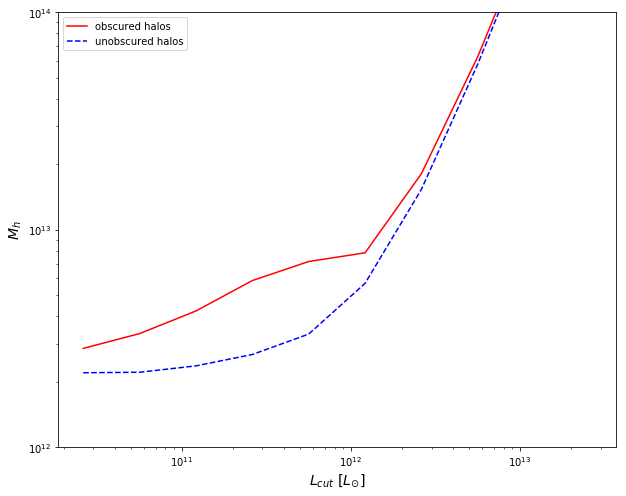

In [33]:
plt.figure(figsize = (10,8))
plt.loglog(Lcutrange, obschalomed, 'r', label = 'obscured halos')
plt.loglog(Lcutrange, unobschalomed, 'b--', label = 'unobscured halos')
axes = plt.gca()
axes.set_ylim([1e12, 1e14])
#plt.axvline(9e11, color = 'g')
plt.xlabel('$L_{cut} \ [L_{\odot}]$', fontsize = 14)
plt.ylabel('$M_{h}$', fontsize = 14)
plt.legend()

## Things to do:
### 1. See what happens if you tweak the Eddington ratio - obscured fraction relation a bit (from Ricci et al.). For example, make it completely flat as it goes to low Eddington ratio, instead of peaking and turning back down slightly (remember the errors on the low Eddington side are fairly large).
